In [19]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
base_dir = '/content/drive/MyDrive/Indonesia_Batik'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Image Aug

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    channel_shift_range=20,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1054: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


In [23]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1830 images belonging to 13 classes.
Found 260 images belonging to 13 classes.
Found 130 images belonging to 13 classes.


# Modelling

In [24]:
base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

<ipython-input-24-718996726>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [25]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation="softmax")
])

In [26]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [27]:
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Testing

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=15,
    restore_best_weights=True,
    min_delta=0.001,
    mode="max",
    baseline=0.92
)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

base_model.trainable = True
for layer in base_model.layers[:30]:
    layer.trainable = False


# Re-compile untuk Fine-Tuning

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# Training Kedua (Fine-Tuning)
history_finetune = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)


# Evaluasi Model

test_loss, test_acc = model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1286: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 43s 572ms/step - accuracy: 0.3010 - loss: 2.4157 - val_accuracy: 0.7154 - val_loss: 0.9988
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 25s 440ms/step - accuracy: 0.6572 - loss: 1.0574 - val_accuracy: 0.7308 - val_loss: 0.8428
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 442ms/step - accuracy: 0.7278 - loss: 0.8694 - val_accuracy: 0.7462 - val_loss: 0.7795
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 451ms/step - accuracy: 0.7596 - loss: 0.7424 - val_accuracy: 0.7385 - val_loss: 0.7577
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 444ms/step - accuracy: 0.7990 - loss: 0.6282 - val_accuracy: 0.7654 - val_loss: 0.7154
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 442ms/step - accuracy: 0.7948 - loss: 0.6089 - val_accuracy: 0.7731 - val_loss: 0.6765
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 442ms/step - accuracy: 0.8203 - loss: 0.5901 - val_accuracy: 0.7846 - val_loss: 0.6570
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 445ms/step - accuracy: 0.8125 - loss: 0.5604 - val_accu

In [29]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 767ms/step
Classification Report:

               precision    recall  f1-score   support

Bokor-Kencono       0.91      1.00      0.95        10
       Kawung       0.90      0.90      0.90        10
 Mega-Mendung       1.00      1.00      1.00        10
       Parang       1.00      0.90      0.95        10
  Sekar-Jagad       0.80      0.80      0.80        10
    Sidoluhur       0.91      1.00      0.95        10
    Sidomukti       1.00      0.90      0.95        10
    Sidomulyo       0.82      0.90      0.86        10
     Srikaton       0.83      1.00      0.91        10
    Tribusono       1.00      1.00      1.00        10
      Truntum       1.00      0.80      0.89        10
Wahyu-Tumurun       0.83      1.00      0.91        10
      Wirasat       1.00      0.70      0.82        10

     accuracy                           0.92       130
    macro avg       0.92      0.92      0.91       130
 weighted avg       0.92      0.92      0.91       130


In [30]:
class_labels = [
    'Bokor-Kencono',
    'Kawung',
    'Mega-Mendung',
    'Parang',
    'Sekar-Jagad',
    'Sidoluhur',
    'Sidomukti',
    'Sidomulyo',
    'Srikaton',
    'Tribusono',
    'Truntum',
    'Wahyu-Tumurun',
    'Wirasat'
]

# Informasi budaya untuk masing-masing motif
batik_info = {
    "bokor_kencono": {
    "name": "Batik Bokor Kencono",
    "description": "Melambangkan kemakmuran dan kehormatan dalam budaya Jawa.",
    "origin": "Surakarta"
  },
  "kawung": {
    "name": "Batik Kawung",
    "description": "Motif geometris berbentuk bulatan menyerupai buah kawung (aren), melambangkan kesucian dan keadilan.",
    "origin": "Yogyakarta"
  },
  "mega_mendung": {
    "name": "Batik Mega Mendung",
    "description": "Bermotif awan bergelombang, melambangkan ketenangan dan kesabaran.",
    "origin": "Cirebon"
  },
  "parang": {
    "name": "Batik Parang",
    "description": "Motif diagonal bersambung menyerupai ombak, melambangkan kekuatan dan perjuangan.",
    "origin": "Yogyakarta"
  },
  "sekar_jagad": {
    "name": "Batik Sekar Jagad",
    "description": "Motif peta bunga dunia, melambangkan keindahan dan keragaman budaya.",
    "origin": "Yogyakarta dan Surakarta"
  },
  "sidoluhur": {
    "name": "Batik Sidoluhur",
    "description": "Melambangkan harapan menjadi pribadi yang terhormat dan bermartabat.",
    "origin": "Yogyakarta"
  },
  "sidomukti": {
    "name": "Batik Sidomukti",
    "description": "Motif ini menyimbolkan kemakmuran dan kebahagiaan yang berkelanjutan.",
    "origin": "Surakarta"
  },
  "sidomulyo": {
    "name": "Batik Sidomulyo",
    "description": "Mengandung harapan akan kehidupan yang mulia dan sejahtera.",
    "origin": "Surakarta"
  },
  "srikaton": {
    "name": "Batik Srikaton",
    "description": "Motif ini melambangkan kemuliaan dan kemakmuran yang agung.",
    "origin": "Surakarta"
  },
  "tribusono": {
    "name": "Batik Tribusono",
    "description": "Motif klasik dengan nilai historis yang tinggi, melambangkan keselarasan.",
    "origin": "Surakarta"
  },
  "truntum": {
    "name": "Batik Truntum",
    "description": "Melambangkan cinta yang tumbuh kembali dan tak pernah padam, sering dipakai dalam pernikahan.",
    "origin": "Surakarta"
  },
  "wahyu_tumurun": {
    "name": "Batik Wahyu Tumurun",
    "description": "Melambangkan harapan akan turunnya wahyu (berkah) dan kemuliaan dari Tuhan.",
    "origin": "Surakarta"
  },
  "wirasat": {
    "name": "Batik Wirasat",
    "description": "Motif ini menyiratkan pesan dan harapan bijak dari orang tua kepada anaknya.",
    "origin": "Surakarta"
    }
}


In [31]:
def predict_batik_from_upload(model, file_path, class_labels, batik_info, threshold=0.5):
    # Preprocessing gambar
    img = tf.keras.preprocessing.image.load_img(file_path, target_size=(150, 150))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0) / 255.0

    # Prediksi model
    predictions = model.predict(img_array)
    confidence = float(np.max(predictions))
    predicted_class_idx = int(np.argmax(predictions))

    # Cek confidence threshold
    if confidence < threshold:
        return {
            "prediction": "Motif tidak dikenali",
            "confidence": confidence,
            "info": None
        }

    # Ambil nama class dan info budaya
    class_name = class_labels[predicted_class_idx]
    info_key = class_name.lower().replace("-", "_").replace(" ", "_")
    info = batik_info.get(info_key, None)

    return {
        "prediction": class_name,
        "confidence": confidence,
        "info": info
    }


In [32]:
# Example - replace with an actual image path from your dataset
image_path = '/content/drive/MyDrive/Indonesia_Batik/test/Parang/-1-_jpg.rf.b6a04b8af468e4ad447b8725a0110e43.jpg'  # Change this to your actual image path

result = predict_batik_from_upload(
    model=model,
    file_path=image_path,
    class_labels=class_labels,
    batik_info=batik_info,
    threshold=0.5
)

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
{'prediction': 'Parang', 'confidence': 0.9999961853027344, 'info': {'name': 'Batik Parang', 'description': 'Motif diagonal bersambung menyerupai ombak, melambangkan kekuatan dan perjuangan.', 'origin': 'Yogyakarta'}}


In [33]:
def predict_batik_from_directory(model, dir_path, class_labels, batik_info, threshold=0.5):
    results = []
    for filename in os.listdir(dir_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(dir_path, filename)
            try:
                # Use the original prediction function
                result = predict_batik_from_upload(model, file_path, class_labels, batik_info, threshold)
                results.append((filename, result))
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    return results

# Then call it with:
# directory_results = predict_batik_from_directory(model, '/content/drive/MyDrive/Indonesia_Batik/test/Parang', class_labels, batik_info)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


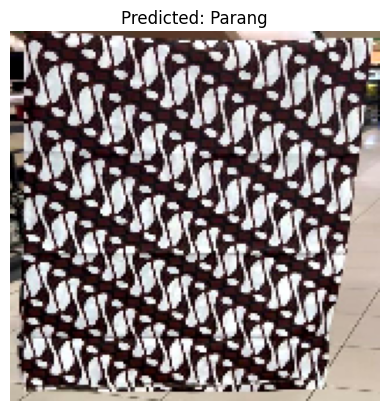

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
{'prediction': 'Parang', 'confidence': 0.9999961853027344, 'info': {'name': 'Batik Parang', 'description': 'Motif diagonal bersambung menyerupai ombak, melambangkan kekuatan dan perjuangan.', 'origin': 'Yogyakarta'}}


In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = '/content/drive/MyDrive/Indonesia_Batik/test/Parang/-1-_jpg.rf.b6a04b8af468e4ad447b8725a0110e43.jpg'

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=(160, 160))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_array)
predicted_class = list(train_generator.class_indices.keys())[np.argmax(prediction)]

# Visualisasi
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

result = predict_batik_from_upload(
    model=model,
    file_path=image_path,
    class_labels=class_labels,
    batik_info=batik_info,
    threshold=0.5
)

print(result)


In [35]:
import tensorflow as tf

# Simpan model ke format .h5
model.save('model_batik.h5')  # Format HDF5 (lama)

# Simpan model ke format .keras (format baru TensorFlow)
model.save('model_batik.keras')  # Format Keras v3 (direkomendasikan)

print("Model berhasil disimpan dalam format .h5 dan .keras!")

Model berhasil disimpan dalam format .h5 dan .keras!


In [36]:
from google.colab import drive
drive.mount('/content/drive')

# Simpan ke Google Drive
model.save('/content/drive/MyDrive/model_batik.h5')
model.save('/content/drive/MyDrive/model_batik.keras')

print("Model berhasil disimpan di Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model berhasil disimpan di Google Drive!
